In [1]:
#Written using Python 3.9.7
#Author: icebreaker, April 2022
#Shoutout to Pai-Sho for the archive node scraping code which I have shamelessly adapted
#N.B. Some (see: most) of this code is ugly, apologies in advance for the lack of comments too, feel free to ping me on discord if you have questions, or would like to collab

from time import sleep, time
import requests, json
from web3 import Web3
import numpy as np
from scipy.stats import norm
from os.path import exists
from hexbytes import HexBytes
from datetime import datetime
import pandas as pd
from enum import Enum
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
from matplotlib import patches as mpatches
import os

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")

INFURA_KEY = os.getenv("INFURA_KEY")
ETHERSCAN_API_KEY = os.getenv("ETHERSCAN_API_KEY")

ETHERSCAN_API_BASE_URL = "https://api.etherscan.io/api"

w3 = Web3(Web3.HTTPProvider("https://mainnet.infura.io/v3/{}".format(INFURA_KEY)))

In [ ]:
## 
##DOWNLOAD & PROCESS ALL BORROW EVENTS FOR KD POOLs v2->v4, get high level TX details, called in next 
def findTargetTX(startBlock, blockStep, _targetContract, _targetEventTopicSignature, _fileNamePreFix):
    targetContract = _targetContract
    targetEventTopicSignature = _targetEventTopicSignature
    fileNamePreFix = _fileNamePreFix
    latestBlockNumber = startBlock
    currentBlockNumber = w3.eth.get_block_number()
    borrowTransactions = []

    while latestBlockNumber < currentBlockNumber:
        borrowFilter = w3.eth.filter(
            {
                "fromBlock": latestBlockNumber,
                "toBlock": latestBlockNumber + blockStep,
                "address": targetContract,
                "topics": [targetEventTopicSignature],
            }
        )
        borrowLogs = w3.eth.get_filter_logs(borrowFilter.filter_id)

        if len(borrowLogs):
            ts = pd.to_datetime((w3.eth.get_block(latestBlockNumber)["timestamp"]), unit='s').to_datetime64()
            print(
                datetime.now().strftime("%H:%M:%S"), 
                "Time: {} Covering Block {}-{}: Found {} {} Pool Borrow events".format(
                    ts,
                    latestBlockNumber,
                    latestBlockNumber + blockStep,
                    len(borrowLogs),
                    fileNamePreFix
                )
            )
            idx = 0
            # For each borrow log found, scrape the txn involving that log and get gas data
            for log in borrowLogs:
                print("Getting TX ", idx, "  of", len(borrowLogs))
                txnHash = log["transactionHash"]

                txn = w3.eth.get_transaction(txnHash)
                gasLimit = txn["gas"]
                gasPrice = txn["gasPrice"]
                blockNumber = txn["blockNumber"]

                txnReceipt = w3.eth.get_transaction_receipt(txnHash)
                gasUsed = txnReceipt["gasUsed"]

                block = w3.eth.get_block(blockNumber)
                timestamp = block["timestamp"]

                dataStr = log["data"][2:]
                data = [dataStr[i : i + 64] for i in range(0, len(dataStr), 64)]

                borrowTransactions.append(
                    {
                        "txHash": txnHash.hex(),
                        "_borrower": HexBytes(log.topics[1])[-20:].hex(),
                        "_token": HexBytes(log.topics[2])[-20:].hex(),
                        "amount": "0x" + data[0][-40:],
                        "fee": "0x" + data[1][-40:],
                        "gasLimit": int(gasLimit),
                        "gasUsed": int(gasUsed),
                        "gasPrice": int(gasPrice),
                        "timestamp": timestamp,
                        "blockNumber": blockNumber,
                        "from": txn["from"],
                        "to": txn["to"]
                    }
                )
                idx += 1
        latestBlockNumber += blockStep
        # sleep to avoid getting rate limited
        sleep(0.01)
        np.save(fileNamePreFix + "borrowTransactions", np.array(borrowTransactions), allow_pickle=True)

    # Save all the order fill data in a pickle file
    print("Found {} total lendingpool ", fileNamePreFix ," fills".format(len(borrowTransactions)))
    return borrowTransactions


In [ ]:
v2LPAddress = '0x53463cd0b074E5FDafc55DcE7B1C82ADF1a43B2E'
v3LPAddress = '0x35fFd6E268610E764fF6944d07760D0EFe5E40E5'
v4LPAddress = '0x4F868C1aa37fCf307ab38D215382e88FCA6275E2'
borrowTopicSignature = '0xc14e9e6b4d98a542b05a0f6b64acd5f4cbdb914be88432d87486b664e97071a7'
currentBlockNumber = w3.eth.get_block_number()

#Finding and scraping onchain tx's of interest takes approximately ~2 hours via infura
v2Events = findTargetTX(11241693, currentBlockNumber, v2LPAddress, borrowTopicSignature, 'v2')
v3Events = findTargetTX(11755954, currentBlockNumber, v3LPAddress, borrowTopicSignature, 'v3')
v4Events = findTargetTX(12699111, currentBlockNumber, v4LPAddress, borrowTopicSignature, 'v4')

columnsFromScrape = ["txHash", "_borrower", "_token", "amount","fee", "gasLimit", "gasUsed","gasPrice","timestamp","blockNumber","from","to"]

v2Events = pd.DataFrame(v2Events, columns = columnsFromScrape)
v3Events = pd.DataFrame(v3Events, columns = columnsFromScrape)
v4Events = pd.DataFrame(v4Events, columns = columnsFromScrape)

v2Events['poolVersion'] = "v2"
v3Events['poolVersion'] = "v3"
v4Events['poolVersion'] = "v4"

combinedFills = pd.concat([v2Events, v3Events, v4Events])
combinedFills.to_csv('borrowFillsCombinedMasterFile.csv')

In [ ]:
#Raw TX enrichment step
#Stateless start of enriching raw TX's, reread everything if required from csv's
#Add in asset label, USD mark, decimals, unix -> human readable date
borrowEvents = pd.read_csv("borrowFillsCombinedMasterFile.csv") #<- Generated above
addressTable = pd.read_csv("identitiesAnonymised.csv") #<- Via KD API, Github version is anonymised, full ID's avail on request
priceTable = pd.read_csv("assetMarks.csv") #<- Pull from your favourite API to refresh or add ETH & BTC close prices, code not included here, used to generate a $ value for m2m valuation

borrowEvents['_tokenSymbol'] = borrowEvents['_token'].map(
    {'0x6b175474e89094c44da98b954eedeac495271d0f': 'DAI', 
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 'USDC',
    '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee': 'ETH',
    '0xeb4c2781e4eba804ce9a9803c67d0893436bb27d': 'renBTC',
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 'WETH'})

borrowEvents['_tokenDecimals'] = borrowEvents['_token'].map(
    {'0x6b175474e89094c44da98b954eedeac495271d0f': 18, 
    '0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48': 6,
    '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee': 18,
    '0xeb4c2781e4eba804ce9a9803c67d0893436bb27d': 8,
    '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2': 18})

#Convert Amount borrowed from Base16 to Decimal and adjust for token decimals
borrowEvents = pd.merge(borrowEvents, 
                     addressTable, 
                     left_on ='_borrower', 
                     right_on ='address', 
                     how ='left')

In [ ]:
#Convert Amount borrowed from Base16 to Decimal and adjust for token decimals
borrowEvents['datetime'] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S.%f')[:-3], borrowEvents["timestamp"]))
borrowEvents['datetimePK'] = list(map(lambda x: datetime.fromtimestamp(x).strftime('%d/%m/%Y'), borrowEvents["timestamp"]))
borrowEvents['datetimePK'] = borrowEvents['datetimePK'] + "-" + borrowEvents['_tokenSymbol']

#Generate Price Marks
pktETH = pd.DataFrame()
pktWETH = pd.DataFrame()
pktBTC = pd.DataFrame()
pktDAI = pd.DataFrame()
pktUSDC = pd.DataFrame()
pkt = pd.DataFrame()

pktETH['datetimePK'] = priceTable['Date']+"-ETH"
pktETH['mark'] = priceTable['ETH']
pktWETH['datetimePK'] = priceTable['Date']+"-WETH"
pktWETH['mark'] = priceTable['ETH']
pktBTC['datetimePK'] = priceTable['Date']+"-renBTC"
pktBTC['mark'] = priceTable['renBTC']
pktDAI['datetimePK'] = priceTable['Date']+"-DAI"
pktDAI['mark'] = 1
pktUSDC['datetimePK'] = priceTable['Date']+"-USDC"
pktUSDC['mark'] = 1
pkt = pd.concat([pktETH, pktWETH, pktBTC, pktDAI, pktUSDC], ignore_index=True)

borrowEvents = pd.merge(borrowEvents, 
                     pkt, 
                     left_on ='datetimePK', 
                     right_on ='datetimePK', 
                     how ='left')

borrowEvents['nominalAmountBorrowed'] = list(map(lambda x: int(x,16), borrowEvents['amount'])) / 10** borrowEvents['_tokenDecimals']
borrowEvents['dollarAmountBorrowed'] = borrowEvents['nominalAmountBorrowed'] * borrowEvents['mark']
borrowEvents['feeDecoded'] = list(map(lambda x: int(x,16),borrowEvents['fee'])) / 10** borrowEvents['_tokenDecimals']
borrowEvents['feeDecoded'] = borrowEvents['feeDecoded']  * borrowEvents['mark']

del pkt, pktUSDC, pktBTC, pktETH, pktWETH, pktDAI, priceTable, borrowEvents['datetimePK']


In [ ]:
#With the enriched borrow event details, save them down if required, 1x general purpose dump, 1x ninja specific dump which we use for our analysis in next cells
ninjaBorrowEvents = borrowEvents[borrowEvents['name'] == 'ninja']
ninjaBorrowEvents = ninjaBorrowEvents[ninjaBorrowEvents['poolVersion'] == 'v4']

ninjaBorrowEvents.to_csv("NinjaFills.csv")
borrowEvents.to_csv("borrowEvents.csv")

In [ ]:
##PART TWO, Using Ninja Events identified above, 
#Scrape out actual events and topic information and compute the PnL associated with the tx, 
#PnL computation is done by isolating transfer events and then accounting for the order in which they are conducted, direction and asset involved
transferTopicSignature = "0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef"
borrowTransactions = []
borrowEvents = pd.read_csv("NinjaFills.csv")
pnlList = []

for log in range(0, len(borrowEvents)):
    print("Getting TX ", log, "  of", len(borrowEvents))
    txnHash = borrowEvents['txHash'][log]
    borrowedAsset = borrowEvents['_token'][log].lower()
    #Handle ETH getting wrapped to WETH case
    if borrowedAsset == '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee':
        borrowedAsset = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'

    borrowedAssetDecimals = borrowEvents['_tokenDecimals'][log]
    borrowedAssetSymbol = borrowEvents['_tokenSymbol'][log]
    mark = borrowEvents['mark'][log]

    txnReceipt = w3.eth.get_transaction_receipt(txnHash)
    transfers = []
    transferSize = []
    for transfer in range(0, len(txnReceipt.logs)):
        if txnReceipt.logs[transfer].topics[0].hex() == transferTopicSignature:
            if txnReceipt.logs[transfer].address.lower() == borrowedAsset:
                transfers.append(txnReceipt.logs[transfer])
                transferSize.append(int(txnReceipt.logs[transfer].data, 16)/ 10** borrowedAssetDecimals)
    
    #Compute PnL, I have checked probably 40 tx's of varying complexity/taxonomies that the computed PnL lines up with etherscan, might be the odd non material edge case not fully captured, but it should be 99% accurate
    transferSize.sort() 
    pnl = 0
    overBorrowed = False
    transfersRecordedInBorrowedAsset = len(transferSize) 
    
    try:
        #Edge Case 1: Check funds havent been overborrowed, if they have then apply alternative PnL calculation method, check based on delta in distance between trade legs not exceeding 15%
        if ((transferSize[-1] / transferSize[1])> 1.15): 
            overBorrowed = True
            print("Overborrow detected")
            pnl = transferSize[2]-transferSize[1]
    except:
            print("error",txnHash, transferSize)
    try:
        if (transfersRecordedInBorrowedAsset <= 2 and overBorrowed == False):
        #Takes the edge case for a simple arb over two pools, n.b. this case is not a common tx type
            pnl = transferSize[1]-transferSize[0]
        elif overBorrowed == False:
        #General Arbitrage Case 
            pnl = transferSize[-1]-transferSize[1]
    except: 
            print("error",txnHash, transferSize)
        
    #print("PnL for ", borrowedAssetSymbol, txnHash, pnl, overBorrowed, transfersRecordedInBorrowedAsset)
    pnlList.append([txnHash, borrowedAsset, transferSize, borrowedAssetSymbol, pnl, mark, overBorrowed, transfersRecordedInBorrowedAsset])

    # sleep to avoid getting rate limited
    sleep(0.01)
    
pnlList = pd.DataFrame (pnlList, columns = ['txHash','borrowedAsset',  'transferSize', 'borrowedAssetSymbol', 'pnl', 'mark','overBorrowed', 'transfersRecordedInBorrowedAsset'])
borrowEvents = pd.merge(borrowEvents, 
                     pnlList, 
                     left_on ='txHash', 
                     right_on ='txHash', 
                     how ='left')
borrowEvents.to_csv('ninjaBorrowsWithPnL.csv')

In [2]:
#Stateless start to Analysing Ninja Flashloan/borrow events overlaid with PnL and enriched TX information
#More Data Munging here
borrowEvents = pd.read_csv("ninjaBorrowsWithPnL.csv", index_col=[0])
borrowEvents.columns = borrowEvents.columns.str.strip().str.replace(' ', '_')
borrowEvents['dollarAmountBorrowed'] = borrowEvents['dollarAmountBorrowed'].str.replace(' ', '')
borrowEvents['dollarAmountBorrowed'] = borrowEvents['dollarAmountBorrowed'].str.replace(',', '')
borrowEvents['dollarAmountBorrowed'] = pd.to_numeric(borrowEvents['dollarAmountBorrowed'], errors='coerce') 
borrowEvents['mark_y'] = pd.to_numeric(borrowEvents['mark_y'], errors='coerce') 
borrowEvents['pnl'] = pd.to_numeric(borrowEvents['pnl'], errors='coerce') 
borrowEvents['dollarPnl'] = borrowEvents['mark_y'] * borrowEvents['pnl']

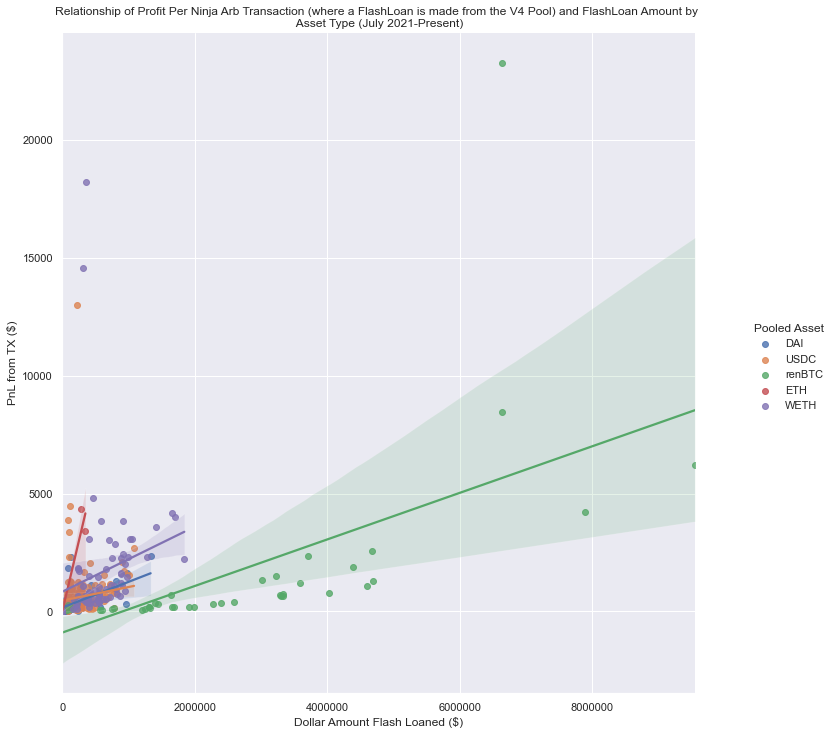

In [3]:
#Produce a general purpose plot for data exploration, showing the relationship of PnL and magnitude of flashloans by ninja, split by asset on poolV4 only
sns.set_theme()
g = sns.lmplot(
    data=borrowEvents,
    x="dollarAmountBorrowed", y="dollarPnl", hue="borrowedAssetSymbol",
    height=10
)
g.set(title='Relationship of Profit Per Ninja Arb Transaction (where a FlashLoan is made from the V4 Pool) and FlashLoan Amount by \n Asset Type (July 2021-Present)')
plt.ticklabel_format(style='plain', axis='x')
g.set_axis_labels("Dollar Amount Flash Loaned ($)", "PnL from TX ($)")
plt.xlim(0, borrowEvents["dollarAmountBorrowed"].max())
g._legend.set_title("Pooled Asset")

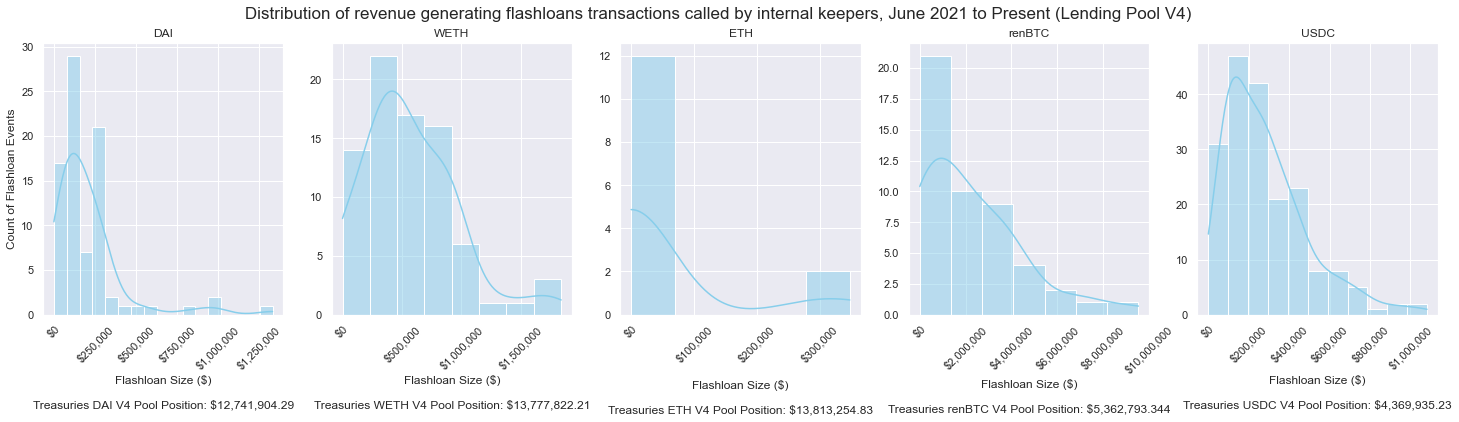

In [48]:
##Produce histrograms to show the distribution of Flashloans by size from ninja on poolv4 borrow events
##UPDATE THESE VAR's as required
COST_OF_CAPITAL = 0.07
annualisationFactor = (294/365) #Pool v4 went live in June-21
balanceSheetComposition  = [['renBTC', 134.8034, 5362793.344], ['DAI', 12741904, 12741904.29], ['WETH', 4604.01, 13777822.21], ['ETH', 4615.8502, 13813254.83], ['USDC', 436935.238, 4369935.238]]
balanceSheetComposition = pd.DataFrame(balanceSheetComposition, columns = ['token', 'nativeAmount', 'usdValue'])

sns.set(style="darkgrid")
fig, axs = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle("Distribution of revenue generating flashloans transactions called by internal keepers, June 2021 to Present (Lending Pool V4)", fontsize=17)

axs[0].title.set_text('DAI')
axs[0].ticklabel_format(style='plain', axis='both')
axs[0].xaxis.set_major_formatter('${x:,.0f}')
axs[0].tick_params(axis='x', labelrotation=45)
plt.setp(axs[0], xlabel='Flashloan Size ($)\n\nTreasuries DAI V4 Pool Position: $12,741,904.29')
plt.setp(axs[0], ylabel='Count of Flashloan Events')
sns.histplot(data=borrowEvents[borrowEvents._tokenSymbol == "DAI"] , x="dollarAmountBorrowed", kde=True, color="skyblue", ax=axs[0])

axs[1].title.set_text('WETH')
axs[1].ticklabel_format(style='plain', axis='both')
axs[1].xaxis.set_major_formatter('${x:,.0f}')
axs[1].tick_params(axis='x', labelrotation=45)
plt.setp(axs[1], xlabel='Flashloan Size ($)\n\nTreasuries WETH V4 Pool Position: $13,777,822.21')
plt.setp(axs[1], ylabel=' ')
sns.histplot(data=borrowEvents[borrowEvents._tokenSymbol == "WETH"] , x="dollarAmountBorrowed", kde=True, color="skyblue", ax=axs[1])

axs[2].title.set_text('ETH')
axs[2].ticklabel_format(style='plain', axis='both')
axs[2].xaxis.set_major_formatter('${x:,.0f}')
axs[2].tick_params(axis='x', labelrotation=45)
plt.setp(axs[2], xlabel='\nFlashloan Size ($)\n\nTreasuries ETH V4 Pool Position: $13,813,254.83')
plt.setp(axs[2], ylabel=' ')
sns.histplot(data=borrowEvents[borrowEvents._tokenSymbol == "ETH"] , x="dollarAmountBorrowed", kde=True, color="skyblue", ax=axs[2])

axs[3].title.set_text('renBTC')
axs[3].ticklabel_format(style='plain', axis='both')
axs[3].xaxis.set_major_formatter('${x:,.0f}')
axs[3].tick_params(axis='x', labelrotation=45)
plt.setp(axs[3], xlabel='Flashloan Size ($)\n\nTreasuries renBTC V4 Pool Position: $5,362,793.344')
plt.setp(axs[3], ylabel=' ')
sns.histplot(data=borrowEvents[borrowEvents._tokenSymbol == "renBTC"] , x="dollarAmountBorrowed", kde=True, color="skyblue", ax=axs[3])

axs[4].title.set_text('USDC')
axs[4].ticklabel_format(style='plain', axis='both')
axs[4].xaxis.set_major_formatter('${x:,.0f}')
axs[4].tick_params(axis='x', labelrotation=45)
plt.setp(axs[4], xlabel='Flashloan Size ($)\n\nTreasuries USDC V4 Pool Position: $4,369,935.23')
plt.setp(axs[4], ylabel=' ')
sns.histplot(data=borrowEvents[borrowEvents._tokenSymbol == "USDC"] , x="dollarAmountBorrowed", kde=True, color="skyblue", ax=axs[4])
plt.show()


In [6]:
#More Data Munging, compute return on equity and balance sheet metrics
#Generate a dataframe outlining per level of assets what the PnL earned is (real and annualised) + what the hurdle rate is

dfrenBTC = borrowEvents[borrowEvents._tokenSymbol == "renBTC"].sort_values(by=['dollarAmountBorrowed'])[["dollarAmountBorrowed", "dollarPnl"]]
dfrenBTC["PnLCumulative"] = dfrenBTC["dollarPnl"].cumsum() 
dfrenBTC["PnLCumulativeAnn"] = dfrenBTC["dollarPnl"].cumsum() * (1/annualisationFactor)
dfrenBTC['hurdlOnCapitalRequired'] = dfrenBTC['dollarAmountBorrowed'] * COST_OF_CAPITAL * annualisationFactor
dfrenBTC["hurdlOnCapitalRequiredAnn"] = dfrenBTC['dollarAmountBorrowed'] * COST_OF_CAPITAL 

dfDAI = borrowEvents[borrowEvents._tokenSymbol == "DAI"].sort_values(by=['dollarAmountBorrowed'])[["dollarAmountBorrowed", "dollarPnl"]]
dfDAI["PnLCumulative"] = dfDAI["dollarPnl"].cumsum() 
dfDAI["PnLCumulativeAnn"] = dfDAI["dollarPnl"].cumsum() * (1/annualisationFactor)
dfDAI['hurdlOnCapitalRequired'] = dfDAI['dollarAmountBorrowed'] * COST_OF_CAPITAL * annualisationFactor
dfDAI["hurdlOnCapitalRequiredAnn"] = dfDAI['dollarAmountBorrowed'] * COST_OF_CAPITAL 

dfWETH = borrowEvents[borrowEvents._tokenSymbol == "WETH"].sort_values(by=['dollarAmountBorrowed'])[["dollarAmountBorrowed", "dollarPnl"]]
dfWETH["PnLCumulative"] = dfWETH["dollarPnl"].cumsum() 
dfWETH["PnLCumulativeAnn"] = dfWETH["dollarPnl"].cumsum() * (1/annualisationFactor)
dfWETH['hurdlOnCapitalRequired'] = dfWETH['dollarAmountBorrowed'] * COST_OF_CAPITAL * annualisationFactor
dfWETH["hurdlOnCapitalRequiredAnn"] = dfWETH['dollarAmountBorrowed'] * COST_OF_CAPITAL 

dfETH = borrowEvents[borrowEvents._tokenSymbol == "ETH"].sort_values(by=['dollarAmountBorrowed'])[["dollarAmountBorrowed", "dollarPnl"]]
dfETH["PnLCumulative"] = dfETH["dollarPnl"].cumsum() 
dfETH["PnLCumulativeAnn"] = dfETH["dollarPnl"].cumsum() * (1/annualisationFactor)
dfETH['hurdlOnCapitalRequired'] = dfETH['dollarAmountBorrowed'] * COST_OF_CAPITAL * annualisationFactor
dfETH["hurdlOnCapitalRequiredAnn"] = dfETH['dollarAmountBorrowed'] * COST_OF_CAPITAL 

dfUSDC = borrowEvents[borrowEvents._tokenSymbol == "USDC"].sort_values(by=['dollarAmountBorrowed'])[["dollarAmountBorrowed", "dollarPnl"]]
dfUSDC["PnLCumulative"] = dfUSDC["dollarPnl"].cumsum() 
dfUSDC["PnLCumulativeAnn"] = dfUSDC["dollarPnl"].cumsum() * (1/annualisationFactor)
dfUSDC['hurdlOnCapitalRequired'] = dfUSDC['dollarAmountBorrowed'] * COST_OF_CAPITAL * annualisationFactor
dfUSDC["hurdlOnCapitalRequiredAnn"] = dfUSDC['dollarAmountBorrowed'] * COST_OF_CAPITAL 

hurdles = [dfrenBTC, dfDAI, dfWETH, dfETH, dfUSDC]


Text(0.5, 0.98, 'Realised revenue vs. required return on equity hurdle, per incremental dollar of treasury balance sheet deployed by asset (V4 LP Pools June 2021 - Present, Annualised)')

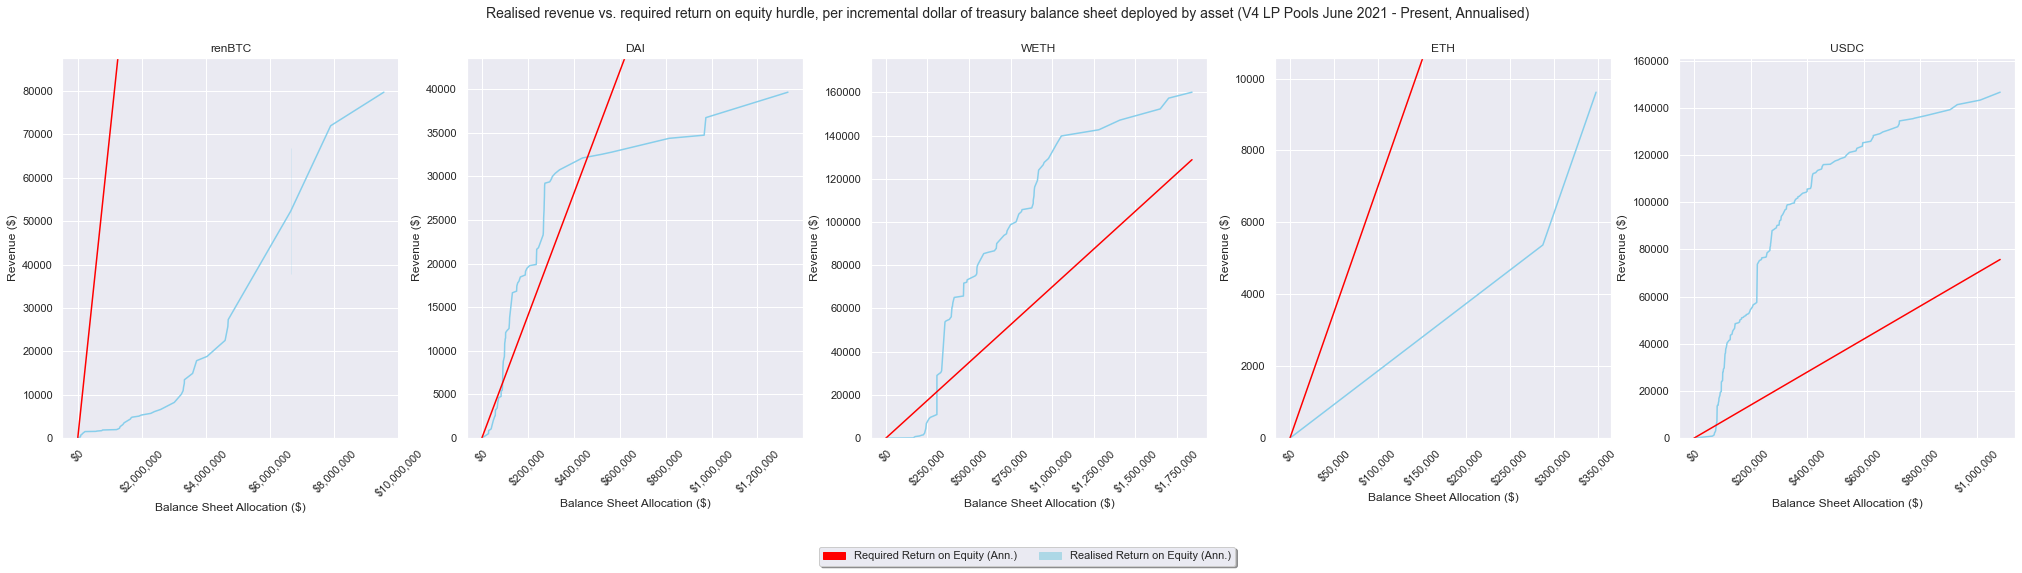

In [40]:
#Produce charts showing value added from incremental dollars added to the pool
fig, ax = plt.subplots(1, len(hurdles), figsize=(35, 7))

xdata = np.arange(50)

sns.set(style="darkgrid")

indexor = 0
for asset in hurdles:
    g1 = sns.lineplot(data=hurdles[indexor], x="dollarAmountBorrowed", y="PnLCumulativeAnn", color="skyblue", ax=ax[indexor])
    g1a = sns.lineplot(data=hurdles[indexor], x="dollarAmountBorrowed", y="hurdlOnCapitalRequiredAnn", color="red", ax=ax[indexor])
    ax[indexor].set_ylim([0, hurdles[indexor]['PnLCumulativeAnn'].max()*1.1])
    #ax[indexor].set_xlim([0, balanceSheetComposition.iloc[indexor]["usdValue"]*1.1])


    ax[indexor].title.set_text(balanceSheetComposition["token"][indexor])
    ax[indexor].ticklabel_format(style='plain', axis='both')
    ax[indexor].xaxis.set_major_formatter('${x:,.0f}')
    ax[indexor].tick_params(axis='x', labelrotation=45)
    plt.setp(ax[indexor], xlabel='Balance Sheet Allocation ($)')
    plt.setp(ax[indexor], ylabel='Revenue ($)')
    indexor += 1 


sp_name = ['Required Return on Equity (Ann.)', 'Realised Return on Equity (Ann.)']
costOfCap = mpatches.Patch(color='red')
pnlCurve = mpatches.Patch(color='#ADD8E6')


plt.legend(labels=sp_name,
           handles=[costOfCap, pnlCurve], bbox_to_anchor=(-1.3, -.35),
           fancybox=True, shadow=True, ncol=5, loc='lower right', )

fig.suptitle("Realised revenue vs. required return on equity hurdle, per incremental dollar of treasury balance sheet deployed by asset (V4 LP Pools June 2021 - Present, Annualised)", fontsize=14)

#plt.tight_layout()


In [33]:
##Compute optimal balance sheet deployment per pool - according to cost of capital assumption.
indexor = 0
economicFactsDF = pd.DataFrame([], columns = [])

for asset in hurdles:
    #Compute Backward looking RoE Balance Sheet Metrics
    assetName = balanceSheetComposition["token"][indexor]
    capitalCurrentlyDeployedDollar = balanceSheetComposition["usdValue"][indexor]
    annRev = asset["PnLCumulativeAnn"].max()
    requiredDollarReturn = capitalCurrentlyDeployedDollar * COST_OF_CAPITAL
    netEconomicPnL = annRev - requiredDollarReturn
    actualROE = annRev / capitalCurrentlyDeployedDollar

    x = asset.sort_values(by=['hurdlOnCapitalRequired'], ascending=False)
    x['optimalPoint'] = x['PnLCumulativeAnn'] -  x['hurdlOnCapitalRequiredAnn']

    #Hacky way to calculate optimal point of capital allocated (i.e. point of $ gain for deploying incremental balance sheet turns negative)
    maxValSeen = 0
    try:
        for location in x['optimalPoint']:
            if location > 0:
                break
            maxValSeen += 1
        optimalBS = x.iloc[maxValSeen]['dollarAmountBorrowed']
        newPnL = x.iloc[maxValSeen]['PnLCumulativeAnn']
        newROE = newPnL / optimalBS

    except:
        optimalBS = 0
        newROE = 0
        newPnL = 0


    if(optimalBS < 1):
        newROE = 0
        newPnL = 0


    newAnnRevEstimateDollar = (newROE * optimalBS)
    economicUpliftEstimateDollar = newAnnRevEstimateDollar - netEconomicPnL
    topRevenueLineChangeDollar = newAnnRevEstimateDollar - annRev

    economicFactsDF = economicFactsDF.append(
        {
        'assetName' : assetName, 
        'currentCapitalDeployedDollar' : capitalCurrentlyDeployedDollar,
        'currentPnLDollarAnn' : annRev, 
        'requiredReturnDollarAnn' : requiredDollarReturn, 
        'currentNetEconomicPnLDollarAnn' : netEconomicPnL, 
        'actualROE' : actualROE, 
        'newOptimisedCapitalDeployedDollar' : optimalBS, 
        'newPnLDollar' : newPnL,
        'newROE' : newROE,
        'newAnnRevEstimateDollar' : newAnnRevEstimateDollar,
        'economicUpliftEstimateDollar' : economicUpliftEstimateDollar
        #Could add something about a topLine Loss
         }, ignore_index=True
        )
    indexor += 1 

print("Optimal Lending Pool Capital Deployment Strategy")
print("Solving with ", COST_OF_CAPITAL * 100, "% cost of equity \n")
print("Total Old B/S Resources:", "${:,.2f}".format(economicFactsDF["currentCapitalDeployedDollar"].sum()))
print("Total New B/S Resources:", "${:,.2f}".format(economicFactsDF["newOptimisedCapitalDeployedDollar"].sum()))
print("Total B/S Resource Change:", "${:,.2f}".format(economicFactsDF["newOptimisedCapitalDeployedDollar"].sum() - economicFactsDF["currentCapitalDeployedDollar"].sum()))
print("Total PnL Uplift ($):", "${:,.2f}".format(economicFactsDF["economicUpliftEstimateDollar"].sum()))

economicFactsDF



Optimal Lending Pool Capital Deployment Strategy
Solving with  7.000000000000001 % cost of equity 

Total Old B/S Resources: $50,065,709.91
Total New B/S Resources: $3,361,328.24
Total B/S Resource Change: $-46,704,381.68
Total PnL Uplift ($): $3,407,735.54


,assetName,currentCapitalDeployedDollar,currentPnLDollarAnn,requiredReturnDollarAnn,currentNetEconomicPnLDollarAnn,actualROE,newOptimisedCapitalDeployedDollar,newPnLDollar,newROE,newAnnRevEstimateDollar,economicUpliftEstimateDollar
0,renBTC,5362793.34,79708.32,375395.53,-295687.22,0.01,0.00,0.00,0.00,0.00,295687.22
1,DAI,12741904.29,39651.14,891933.30,-852282.16,0.00,438427.69,32115.33,0.07,32115.33,884397.49
2,WETH,13777822.21,160095.52,964447.55,-804352.03,0.01,1840829.21,160095.52,0.09,160095.52,964447.55
3,ETH,13813254.83,9620.03,966927.84,-957307.81,0.00,0.00,0.00,0.00,0.00,957307.81
4,USDC,4369935.24,146671.16,305895.47,-159224.31,0.03,1082071.34,146671.16,0.14,146671.16,305895.47
